In [21]:
import numpy as np
from OU_model import generateOUProcess
import matplotlib.pyplot as plt

The [Ornstein-Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) 
is described by the following SDE: 

$$ dX_t = \theta (\mu - X_t) dt + \sigma dW_t .$$

The parameters are:
- $\theta> 0$:  mean reversion coefficient
- $\mu \in \mathbb{R}$:  long term mean  
- $\sigma > 0$:   volatility coefficient


For any given hedge ratio $b$, consider the observed time series of the resulting spread $X_t = S^1_t −bS^2_t$ up to time $t_0$. Then, we apply the method of maximum likelihood estimation to determine the optimal parameters for the OU model based on the historical data.  
We define the average log-likelihood of past $L$ observations as 

$$
\begin{aligned}
l(\mu, \theta, \sigma, b) & =\frac{1}{L} \sum_{\mathrm{i}=t_0-L+1}^{t_0-1} \log f\left(x_{\mathrm{i}} \mid x_{\mathrm{i}-1} ; \mu, \theta, \sigma\right) \\
& =-\frac{1}{2} \ln (2 \pi)-\ln (\tilde{\sigma})-\frac{1}{2 L \tilde{\sigma}^2} \sum_{\mathrm{i}=t_0-L+1}^{t_0-1}\left[x_{\mathrm{i}}-x_{\mathrm{i}-1} \mathrm{e}^{-\mu \Delta t}-\theta\left(1-\mathrm{e}^{-\mu \Delta t}\right)\right]^2,
\end{aligned}
$$
where 
$$
\tilde{\sigma}^2=\sigma^2 \frac{1-\mathrm{e}^{-2 \mu \Delta t}}{2 \mu}
$$

The OU parameter values that maximize the average log-likelihood can be computed:
$$
\begin{aligned}
X_x & =\sum_{\mathrm{i}=1}^n x_{\mathrm{i}-1} \\
X_y & =\sum_{\mathrm{i}=1}^n x_{\mathrm{i}} \\
X_{x x} & =\sum_{\mathrm{i}=1}^n x_{\mathrm{i}-1}^2 \\
X_{x y} & =\sum_{\mathrm{i}=1}^n x_{\mathrm{i}-1} x_{\mathrm{i}} \\
X_{y y} & =\sum_{\mathrm{i}=1}^n x_{\mathrm{i}-1}^2
\end{aligned}
$$
$$
\begin{gathered}
\theta^*=\frac{X_y X_{x x}-X_x X_{x y}}{n\left(X_{x x}-X_{x y}\right)-\left(X_x^2-X_x X_y\right)}, \\
\mu^*=-\frac{1}{\Delta t} \ln \frac{X_{x y}-\theta^* X_x-\theta^* X_y+n\left(\theta^*\right)^2}{X_{x x}-2 \theta^* X_x+n\left(\theta^*\right)^2}, \\
\left(\sigma^*\right)^2=\frac{2 \mu^*}{n\left(1-\mathrm{e}^{-2 \mu^* \Delta t}\right)}\left(X_{y y}-2 \mathrm{e}^{-2 \mu^* \Delta t} X_{x y}+\mathrm{e}^{-2 \mu^* \Delta t} X_{x x}\right. \\
\left.-2 \theta^*\left(1-\mathrm{e}^{-\mu^* \Delta t}\right)\left(X_y-\mathrm{e}^{-\mu^* \Delta t} X_x\right)+n\left(\theta^*\right)^2\left(1-\mathrm{e}^{-\mu^* \Delta t}\right)^2\right) .
\end{gathered}
$$

In [22]:
def computeLogLikelihood(mu, theta, sigma_sq, past_x, dt=1):
    L = len(past_x)
    s = sigma_sq * (1 - np.exp(-2*mu*dt)) / 2 / mu
    ans = -0.5 * np.log(2*np.pi) - np.log(s)
    diff = past_x[1:] - past_x[:-1] * np.exp(-mu*dt) - theta*(1-np.exp(-mu*dt))
    ans -= 0.5/L/s * sum(diff**2)

    return ans


In [23]:
def optimOUParamter(x, dt=1):
    n = len(x)

    Xx = np.sum(x[:-1])
    Xy = Xx + x[-1]
    
    Xxx = np.sum(x[:-1]**2)
    Xxy = np.sum(x[:-1] * x[1:])
    Xyy = Xxx + x[-1]**2
    
    theta = (Xy * Xxx - Xx * Xxy)/(n * (Xxx - Xxy) - (Xx**2 - Xx * Xy))
    mu = -1/dt * np.log((Xxy - theta * Xx - theta * Xy + n*theta**2)/(Xxx - 2*theta*Xx + n*theta**2))
    e = np.exp(-mu*dt)
    sigma_sq = 2*mu /n/(1 - e*e) * (Xyy - 2*e*e*Xxy + e*e*Xxx 
                        -2*theta*(1-e)*(Xy - e*Xx) + n * theta**2 * (1-e)**2)
    return theta, mu, sigma_sq


Given a hedge ratio $b$, we estimate parameters by maximizing log-likelihood
$$
l^*(b)=l\left(\mu^*, \theta^*, \sigma^*, b\right) .
$$
Then it is further optimized over ratio $b$ to give the optimal hedge ratio
$$
B=\underset{b}{\arg \max }\ l^*(b) .
$$
In practice, a grid search is enough to find optimal $b$, if we limit the hedge ratio to be a small number (assume it's 2 hereafter).


In [24]:
def getPastSpread(x, t0, L):
    return x[t0-L:t0]

def gridsearchHedgeRatio(S1, S2, limit_ratio=2, grid_spacing=0.01):
    ans = 0
    max_l = -np.inf
    candidates = np.linspace(-limit_ratio, limit_ratio, round(2*(limit_ratio)/grid_spacing)+1)
    for b in candidates:
        theta, mu, sigma_sq = optimOUParamter(S1 - b*S2)
        past_x = getPastSpread(S1-b*S2, t0=-1, L=10)
        l = computeLogLikelihood(mu, theta, sigma_sq, past_x)
        if l > max_l:
            ans = b
            max_l = l
    return ans


We simulate an example trading with simple distance-based rules below.  
The optimal hedge ratio is estimated from 1 year of historical formation phase, and then fixed for the next year of trading phase.  
A long position of is established if no shares of $X_t$ are held and the price drops below the past $M$ -days average value minus $K$ times standard deviation. We invest all the cash at hand to long $S^1_t$ and short the corresponding $S^2_t$ with the best pair ratio.   
The entire position is liquidated whenever the price of $X_t$ rises beyond the past $M$ -days average value.   
$L$ and $M$ control how much past data should be incorporated in the current trading decisions. The other parameter, $K$, will have direct influence on the timing and frequency of trades. For instance, a smaller $K$ will result in more frequent trading.

0.0, 6.6732113650171785 at day 2
100.18243597428003, 0 at day 4
100.43704088249663, 0 at day 9
0.0, 6.704295607053529 at day 11
100.57393636816079, 0 at day 12
0.0, 6.71071112049307 at day 13
100.7297745369851, 0 at day 14
100.89282296453656, 0 at day 16
100.99595969394433, 0 at day 19
0.0, 6.7404143752579655 at day 21
101.15156364491615, 0 at day 24
0.0, 6.75519342517675 at day 26
101.36497840812876, 0 at day 28
101.5861997735302, 0 at day 30
0.0, 6.7853618449424475 at day 34
101.78067437519674, 0 at day 35
0.0, 6.7925209258441726 at day 43
101.97622494694818, 0 at day 45
0.0, 6.807823642378986 at day 46
102.18840402131009, 0 at day 47
102.33750262003169, 0 at day 52
102.61669140583753, 0 at day 55
102.77642193101599, 0 at day 58
102.94702553440234, 0 at day 66
103.10616236263732, 0 at day 70
103.37564109916921, 0 at day 74
0.0, 6.898848604404158 at day 77
103.51650354266864, 0 at day 78
103.65191271444873, 0 at day 86
0.0, 6.916806302313968 at day 90
103.81795619190332, 0 at day 92
0

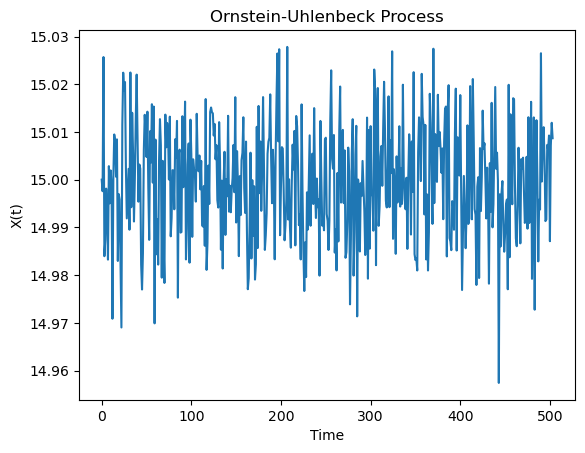

In [27]:
T = 252
M = 30
K = 1.0
stop_loss = 0.2

capital = 100
position = 0
_, all_x = generateOUProcess(theta=40, sigma=0.1, mu=15, X0=15, dt=0.005, T=2*T)
day_x = all_x[[i for i in range(0, 50400*2, 200)]]

for i in range(1, T+1):
    old_position = position
    x = day_x[:T+i]
    # b = gridsearchHedgeRatio(S1, S2, limit_ratio=2)
    # x = S1 - b*S2
    
    MA_x = np.mean(x[-M:])
    SD_x = np.std(x[-M:])
    if position==0 and x[-1] < MA_x - K * SD_x:
        position = capital/np.abs(x[-1])
        capital -= position * x[-1]

    elif position==0 and x[-1] > MA_x + K * SD_x:
        position = - capital/np.abs(x[-1])
        capital -= position * x[-1]

    elif position>0 and x[-1] > MA_x:
        capital += position * x[-1]
        position = 0

    elif position<0 and x[-1] < MA_x:
        capital += position * x[-1]
        position = 0

    elif position>0 and x[-1] < x[T]*(1-stop_loss):
        capital += position * x[-1]
        position = 0

    elif position<0 and x[-1] > x[T]*(1+stop_loss):
        capital += position * x[-1]
        position = 0

    if position != old_position and position>=0:
        print(f"{capital}, {position} at day {i}")

if position!=0:
    capital += position * x[-1]
    position = 0
    print(f"{capital}, {position} at final day")


# Plot results
plt.plot(np.arange(T*2), day_x)
plt.xlabel('Time')
plt.ylabel('X(t)')
plt.title('Ornstein-Uhlenbeck Process')
plt.show()
